В этом ноутбуке будет решена следующая задача: спрогнозировать вернется ли студент к ИИ-помошнику на основе имеющихся данных

In [58]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv('../data/ai_assistant_usage_student_life.csv', parse_dates=True)

df['UsedAgain'] = df['UsedAgain'].astype(int)
display(df.head())

,SessionID,StudentLevel,Discipline,SessionDate,SessionLengthMin,TotalPrompts,TaskType,AI_AssistanceLevel,FinalOutcome,UsedAgain,SatisfactionRating
0,SESSION00001,Undergraduate,Computer Science,2024-11-03,31.20,11,Studying,2,Assignment Completed,1,1.0
1,SESSION00002,Undergraduate,Psychology,2024-08-25,13.09,6,Studying,3,Assignment Completed,1,2.0
2,SESSION00003,Undergraduate,Business,2025-01-12,19.22,5,Coding,3,Assignment Completed,1,3.3
3,SESSION00004,Undergraduate,Computer Science,2025-05-06,3.70,1,Coding,3,Assignment Completed,1,3.5
4,SESSION00005,Undergraduate,Psychology,2025-03-18,28.12,9,Writing,3,Assignment Completed,1,2.9


In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, roc_auc_score

df = df.drop(["SessionID", "SessionLengthMin", "AI_AssistanceLevel", "SessionDate"], axis=1)
X = df.drop("UsedAgain", axis=1)
y = df["UsedAgain"]

Добавляем библиотеки для обучения модели логистической регрессии, а также удаляем из датасета сильнокоррелирющие признаки с другими, чтобы избежать мультиколлинеарности, в нашем случае (опираясь на первичный анализ) это SessionLengthMin и TotalPrompts, AI_AssistanceLevel и SatisfactionRating. были убраны SessionLengthMin (так как TotalPrompts чуть лучше коррелирует с целевой переменной) и AI_AssistanceLevel (так как SatisfactionRating имеет больше вариантов (рациональные числа против целых) и потому что SatisfactionRating общая оценка сессии в целом, что более важно)

In [60]:
numeric_features     = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features)
])

clf = Pipeline(steps=[
    ("preproc", preprocessor),
    ("model", LogisticRegression(penalty=None, solver="saga", max_iter=20000,
                                fit_intercept=True))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf.fit(X_train, y_train)

print("SKLEARN RESULTS:")
print("Accuracy on test:", clf.score(X_test, y_test))
y_pred = clf.predict(X_test)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

sk_model = clf.named_steps["model"]

sk_coefs = sk_model.coef_[0]
sk_intercept = sk_model.intercept_[0]

#Списки num и cat для statsmodels 
prep = clf.named_steps["preproc"]
num_names = numeric_features
cat_names = prep.named_transformers_["cat"].get_feature_names_out(categorical_features).tolist()
all_names = num_names + cat_names
#-----------------

features = ["const"] + all_names
coef_values = np.concatenate([[sk_intercept], sk_coefs])

sk_coef_df = pd.DataFrame({
    "feature": features,
    "coef_sk": coef_values
})

print("\n SKLEARN COEFFICIENTS:")
print(sk_coef_df)

sk_coef_df["odds_ratio"] = np.exp(sk_coef_df["coef_sk"])
print("\nOdds ratios:\n", sk_coef_df)

#statsmodels модель-------------
X_train_proc = prep.transform(X_train)
if not isinstance(X_train_proc, np.ndarray):
    X_train_proc = X_train_proc.toarray()

X_sm = pd.DataFrame(X_train_proc, columns=all_names, index=X_train.index)
X_sm = sm.add_constant(X_sm)

logit = sm.Logit(y_train, X_sm)
res   = logit.fit(disp=False)

print("\nSTATSMODELS RESULTS:")
print(res.summary())

coef_df = pd.DataFrame({
    "feature": res.params.index,
    "coef":    res.params.values,
    "pval":    res.pvalues.values
}).sort_values("pval")

print("\nTop features by p-value:\n", coef_df)

significant_features = coef_df[coef_df["pval"] < 0.05]

print("\nСтатистически значимые признаки (p-value < 0.05):")
print("=============================================")
print(f"Всего значимых признаков: {len(significant_features)} из {len(coef_df)}\n")

for idx, row in significant_features.iterrows():
    coef_sign = "+" if row["coef"] >= 0 else "-"
    print(f"{row['feature']:30s}: "
          f"коэф. = {row['coef']:7.4f} ({coef_sign}), "
          f"p-value = {row['pval']:.3e}")
    


SKLEARN RESULTS:
Accuracy on test: 0.7432
Confusion matrix:
 [[ 348  386]
 [ 256 1510]]
              precision    recall  f1-score   support

           0       0.58      0.47      0.52       734
           1       0.80      0.86      0.82      1766

    accuracy                           0.74      2500
   macro avg       0.69      0.66      0.67      2500
weighted avg       0.73      0.74      0.74      2500


 SKLEARN COEFFICIENTS:
                        feature   coef_sk
0                         const  1.170662
1                  TotalPrompts  0.020567
2            SatisfactionRating  0.000359
3      StudentLevel_High School  0.057772
4    StudentLevel_Undergraduate  0.014499
5           Discipline_Business  0.014203
6   Discipline_Computer Science  0.132095
7        Discipline_Engineering  0.074736
8            Discipline_History  0.162759
9               Discipline_Math -0.144238
10        Discipline_Psychology  0.054338
11              TaskType_Coding  0.368200
12       TaskTy

Обучаем логистическую модель используя sklearn и statsmodels, для сравнения. Нормализируем числовые признаки и адаптируем к обучению вещественные, задаем модель обучения LogisticRegression. Разделяем на обучающую и тестовую выборку. По результатам можно увидеть, что модели дали практически один и тот же результат, что точность модели 0,743; модель плохо (47% ошибается) предсказывает результат 0, но хорошо 1 (recall = 0,86), это можно изменить в будущем, например повысив порог. также были выведены веса факторов.

ROC-AUC: 0.6675814892875107


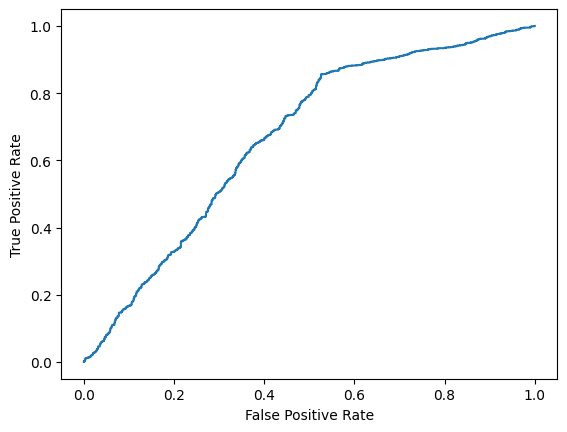

In [61]:
y_proba = clf.predict_proba(X_test)[:, 1] 
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

как можно заметить по ROC-AUC = 0,668 модель не плохо разделяет классы, явно лучше чем угадывание.

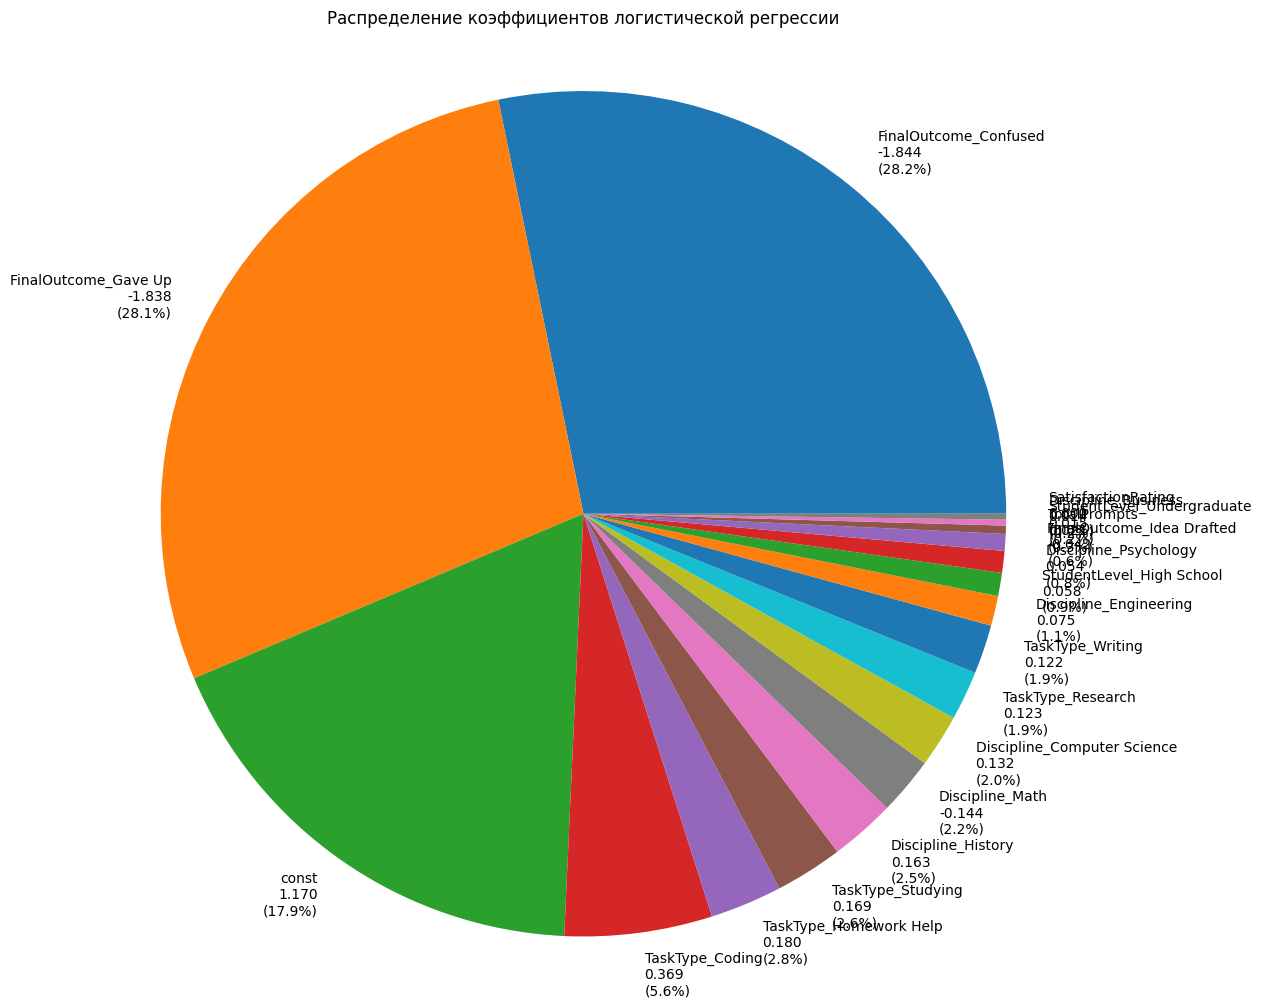

In [62]:
coef_df = pd.DataFrame({
    "feature": res.params.index,
    "coef": res.params.values
})

coef_df['abs_coef'] = np.abs(coef_df['coef'])
coef_df['pct'] = coef_df['abs_coef'] / coef_df['abs_coef'].sum() * 100
coef_df = coef_df.sort_values('abs_coef', ascending=False)

plt.figure(figsize=(12, 12))
plt.pie(
    coef_df['pct'],
    labels=[f"{name}\n{coef:.3f}\n({pct:.1f}%)" 
           for name, coef, pct in zip(coef_df['feature'], coef_df['coef'], coef_df['pct'])],
    startangle=0,
    textprops={'fontsize': 10}
)

plt.title('Распределение коэффициентов логистической регрессии', pad=20)
plt.axis('equal')
plt.show()

Также проанализировав веса модели можно понять, что сильнее всего на предсказывание влияют FinalOutcome_Confused (-1.84) и FinalOutcome_Gave Up (-1.84), сильное отрицательное влияние обоих факторов легко обьяснить, конфузящий результат или вовсе провал скорее всего будет значить, что студент не вернется к ИИ-помошнику. Менее сильно влияет TaskType_Coding, но все же сильно больше чем другие факторы (0,369).

In [63]:
df_concat_cat = sk_coef_df.copy()
df_concat_cat["abs_coef"] = df_concat_cat["coef_sk"].abs()
df_concat_cat["base"] = df_concat_cat["feature"].apply(lambda x: x.split("_")[0] if "_" in x else x)

agg = (
    df_concat_cat
    .groupby("base", as_index=False)
    .agg(total_abs_coef=("abs_coef", "sum"))
)

agg["pct_influence"] = agg["total_abs_coef"] / agg["total_abs_coef"].sum() * 100
agg = agg.sort_values("pct_influence", ascending=False).reset_index(drop=True)

print(agg)

                 base  total_abs_coef  pct_influence
0        FinalOutcome        3.724015      57.022108
1               const        1.170662      17.925169
2            TaskType        0.960585      14.708468
3          Discipline        0.582369       8.917226
4        StudentLevel        0.072271       1.106610
5        TotalPrompts        0.020567       0.314917
6  SatisfactionRating        0.000359       0.005502


как дополнительную информацию, можно изучить влияние конкретных переменных на результат (в процессе обучения качественные признаки были адаптированны для обучения, они были разделены на бинарные переменные).

Далее был написан код для улучшения модели, с помошью удаления не значимых признаков. для проверки групп на значимость, был применен классический тест отношения правдоподобия (Likelihood‐Ratio Test).

In [ ]:
from scipy.stats import chi2

#Улучшение модели, убираем не значимые факторы и проводим X^2-тесты

def train_statsmodels_model(X, y, numeric_features=None, categorical_features=None, test_size=0.25, random_state=42):
    """
    Обучает логистическую регрессию в statsmodels с предобработкой данных
    
    Параметры:
        X: DataFrame с признаками
        y: целевая переменная
        numeric_features: список числовых признаков
        categorical_features: список категориальных признаков
        test_size: размер тестовой выборки
        random_state: random seed
        
    Возвращает:
        model: обученная statsmodels модель
        X_train: обучающие данные (после препроцессинга)
        X_test: тестовые данные (после препроцессинга)
        y_train, y_test: соответствующие целевые переменные
        preprocessor: объект препроцессинга
        feature_names: список всех имен признаков после преобразования
        pvalues_df: DataFrame с p-значениями признаков (отсортированный)
    """
    if numeric_features is None:
        numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    if categorical_features is None:
        categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
    
    preprocessor = ColumnTransformer(transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features)
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    X_train_proc = preprocessor.fit_transform(X_train)
    if not isinstance(X_train_proc, np.ndarray):
        X_train_proc = X_train_proc.toarray()
    
    feature_names = []
    feature_names.extend(numeric_features) 
    
    cat_encoder = preprocessor.named_transformers_["cat"]
    cat_features = cat_encoder.get_feature_names_out(categorical_features)
    feature_names.extend(cat_features)
    
    X_sm = pd.DataFrame(X_train_proc, columns=feature_names, index=X_train.index)
    X_sm = sm.add_constant(X_sm)
    
    model = sm.Logit(y_train, X_sm).fit(disp=False)
    
    pvalues_df = pd.DataFrame({
        'feature': model.params.index,
        'coef': model.params.values,
        'pvalue': model.pvalues.values,
        'significant': model.pvalues < 0.05  
    }).sort_values('pvalue')  
    
    print("\nТаблица значимости признаков (отсортирована по p-value):")
    print("="*70)
    print(pvalues_df.to_string(float_format="{:,.4f}".format))
    print("\nПримечание: 'significant' = True означает p-value < 0.05")
    print("="*70)
    
    return model, X_train, X_test, y_train, y_test, preprocessor, feature_names, pvalues_df

def likelihood_ratio_test(full_model, restricted_model):
    """
    Проводит тест отношения правдоподобий (LRT) для сравнения двух моделей.
    
    Аргументы:
        full_model: обученная statsmodels-модель (включает группу признаков)
        restricted_model: обученная statsmodels-модель (без группы признаков)
    
    Возвращает:
        dict: {
            'lr_stat': статистика теста (χ²),
            'p_value': p-значение,
            'df': степени свободы
        }
    """
    llf_full = full_model.llf
    llf_restricted = restricted_model.llf
    
    lr_stat = -2 * (llf_restricted - llf_full)
    df = full_model.df_model - restricted_model.df_model
    p_value = chi2.sf(lr_stat, df)
    
    return {
        'lr_stat': lr_stat,
        'p_value': p_value,
        'df': df
    }

def test_feature_group(preprocessor, model, X_train, feature_group, all_feature_names):
    """
    Проверяет значимость группы признаков с помощью LRT
    
    Параметры:
        preprocessor: объект препроцессинга
        model: полная statsmodels модель
        X_train: исходные обучающие данные
        feature_group: список имен исходных признаков для тестирования
        all_feature_names: список всех имен признаков после преобразования
    """
    features_to_keep = [f for f in all_feature_names 
                      if not any(f.startswith(group+'_') or f == group 
                      for group in feature_group)]
    
    X_sm_restricted = model.model.exog[:, [i for i, name in enumerate(model.model.exog_names) 
                                     if name in features_to_keep or name == 'const']]
    
    restricted_model = sm.Logit(model.model.endog, X_sm_restricted).fit(disp=False)
    
    return likelihood_ratio_test(model, restricted_model)

model, X_train, X_test, y_train, y_test, preprocessor, feature_names, pvalue_df = train_statsmodels_model(X, y)

#print(feature_names)

group_test_result = test_feature_group(
    preprocessor=preprocessor,
    model=model,
    X_train=X_train,
    feature_group=["SatisfactionRating"], 
    all_feature_names=feature_names
)

print("\nРезультаты группового теста:")
print(f"LR статистика: {group_test_result['lr_stat']:.5f}")
print(f"p-value: {group_test_result['p_value']:.5f}")
print(f"Степени свободы: {group_test_result['df']}")

#print(pvalue_df)


Таблица значимости признаков (отсортирована по p-value):
                                                 feature    coef  pvalue  significant
FinalOutcome_Confused              FinalOutcome_Confused -1.8442  0.0000         True
FinalOutcome_Gave Up                FinalOutcome_Gave Up -1.8377  0.0000         True
const                                              const  1.1702  0.0000         True
TaskType_Coding                          TaskType_Coding  0.3686  0.0086         True
Discipline_History                    Discipline_History  0.1628  0.1160        False
Discipline_Math                          Discipline_Math -0.1442  0.1531        False
TaskType_Homework Help            TaskType_Homework Help  0.1797  0.1947        False
Discipline_Computer Science  Discipline_Computer Science  0.1322  0.1956        False
TaskType_Studying                      TaskType_Studying  0.1690  0.2185        False
TaskType_Writing                        TaskType_Writing  0.1223  0.3580        Fa

In [ ]:
#1. удаляем SatisfactionRating
categorical_features_ftest = categorical_features.copy()
numeric_features_ftest = numeric_features.copy()
numeric_features_ftest.remove('SatisfactionRating')

model, X_train, X_test, y_train, y_test, preprocessor, feature_names, pvalue_df = train_statsmodels_model(X, y, numeric_features_ftest, categorical_features_ftest)

#print(feature_names)
#print(numeric_features)

group_test_result = test_feature_group(
    preprocessor=preprocessor,
    model=model,
    X_train=X_train,
    feature_group=["Discipline"],  
    all_feature_names=feature_names
)

print("\nРезультаты группового теста:")
print(f"LR статистика: {group_test_result['lr_stat']:.5f}")
print(f"p-value: {group_test_result['p_value']:.5f}")
print(f"Степени свободы: {group_test_result['df']}")


Таблица значимости признаков (отсортирована по p-value):
                                                 feature    coef  pvalue  significant
FinalOutcome_Confused              FinalOutcome_Confused -1.8442  0.0000         True
FinalOutcome_Gave Up                FinalOutcome_Gave Up -1.8377  0.0000         True
const                                              const  1.1702  0.0000         True
TaskType_Coding                          TaskType_Coding  0.3686  0.0086         True
Discipline_History                    Discipline_History  0.1628  0.1160        False
Discipline_Math                          Discipline_Math -0.1442  0.1531        False
TaskType_Homework Help            TaskType_Homework Help  0.1797  0.1947        False
Discipline_Computer Science  Discipline_Computer Science  0.1321  0.1956        False
TaskType_Studying                      TaskType_Studying  0.1690  0.2185        False
TaskType_Writing                        TaskType_Writing  0.1223  0.3579        Fa

In [ ]:
#2. удаляем Discipline
categorical_features_ftest.remove("Discipline")


model, X_train, X_test, y_train, y_test, preprocessor, feature_names, pvalue_df = train_statsmodels_model(X, y, numeric_features_ftest, categorical_features_ftest)

#print(feature_names)
#print(numeric_features)

group_test_result = test_feature_group(
    preprocessor=preprocessor,
    model=model,
    X_train=X_train,
    feature_group=["StudentLevel"],  
    all_feature_names=feature_names
)

print("\nРезультаты группового теста:")
print(f"LR статистика: {group_test_result['lr_stat']:.5f}")
print(f"p-value: {group_test_result['p_value']:.5f}")
print(f"Степени свободы: {group_test_result['df']}")


Таблица значимости признаков (отсортирована по p-value):
                                               feature    coef  pvalue  significant
FinalOutcome_Confused            FinalOutcome_Confused -1.8375  0.0000         True
FinalOutcome_Gave Up              FinalOutcome_Gave Up -1.8324  0.0000         True
const                                            const  1.2042  0.0000         True
TaskType_Coding                        TaskType_Coding  0.3750  0.0075         True
TaskType_Homework Help          TaskType_Homework Help  0.1844  0.1828        False
TaskType_Studying                    TaskType_Studying  0.1741  0.2043        False
TaskType_Writing                      TaskType_Writing  0.1237  0.3522        False
TotalPrompts                              TotalPrompts  0.0215  0.4342        False
TaskType_Research                    TaskType_Research  0.1333  0.4391        False
StudentLevel_High School      StudentLevel_High School  0.0576  0.5044        False
FinalOutcome_Idea 

In [ ]:
#3. удаляем StudentLevel	
categorical_features_ftest.remove("StudentLevel")

model, X_train, X_test, y_train, y_test, preprocessor, feature_names, pvalue_df = train_statsmodels_model(X, y, numeric_features_ftest, categorical_features_ftest)

#print(feature_names)
#print(numeric_features)

group_test_result = test_feature_group(
    preprocessor=preprocessor,
    model=model,
    X_train=X_train,
    feature_group=["FinalOutcome"],  
    all_feature_names=feature_names
)

print("\nРезультаты группового теста:")
print(f"LR статистика: {group_test_result['lr_stat']:.5f}")
print(f"p-value: {group_test_result['p_value']:.5f}")
print(f"Степени свободы: {group_test_result['df']}")


Таблица значимости признаков (отсортирована по p-value):
                                             feature    coef  pvalue  significant
FinalOutcome_Confused          FinalOutcome_Confused -1.8372  0.0000         True
FinalOutcome_Gave Up            FinalOutcome_Gave Up -1.8326  0.0000         True
const                                          const  1.2235  0.0000         True
TaskType_Coding                      TaskType_Coding  0.3747  0.0075         True
TaskType_Homework Help        TaskType_Homework Help  0.1847  0.1820        False
TaskType_Studying                  TaskType_Studying  0.1759  0.1995        False
TaskType_Writing                    TaskType_Writing  0.1243  0.3498        False
TotalPrompts                            TotalPrompts  0.0214  0.4361        False
TaskType_Research                  TaskType_Research  0.1340  0.4368        False
FinalOutcome_Idea Drafted  FinalOutcome_Idea Drafted -0.0372  0.5901        False

Примечание: 'significant' = True означа

In [ ]:
#4. оставляем FinalOutcome

#print(feature_names)
#print(numeric_features)

group_test_result = test_feature_group(
    preprocessor=preprocessor,
    model=model,
    X_train=X_train,
    feature_group=["TaskType"], 
    all_feature_names=feature_names
)

print("\nРезультаты группового теста:")
print(f"LR статистика: {group_test_result['lr_stat']:.5f}")
print(f"p-value: {group_test_result['p_value']:.5f}")
print(f"Степени свободы: {group_test_result['df']}")


Результаты группового теста:
LR статистика: 12.48402
p-value: 0.02873
Степени свободы: 5.0


In [73]:
#5. оставляем TaskType

#print(feature_names)
#print(numeric_features)

group_test_result = test_feature_group(
    preprocessor=preprocessor,
    model=model,
    X_train=X_train,
    feature_group=["TotalPrompts"], 
    all_feature_names=feature_names
)

print("\nРезультаты группового теста:")
print(f"LR статистика: {group_test_result['lr_stat']:.5f}")
print(f"p-value: {group_test_result['p_value']:.5f}")
print(f"Степени свободы: {group_test_result['df']}")

#6. удаляем TotalPrompts
numeric_features_ftest.remove('TotalPrompts')


Результаты группового теста:
LR статистика: 0.60913
p-value: 0.43512
Степени свободы: 1.0


В ходе тестов были удалены признаки: StudentLevel, Discipline, TotalPrompts, SatisfactionRating.


В итоговой модели останутся только: FinalOutcome и TaskType.


In [74]:
numeric_features     = numeric_features_ftest.copy()
categorical_features = categorical_features_ftest.copy()

preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features)
])

clf = Pipeline(steps=[
    ("preproc", preprocessor),
    ("model", LogisticRegression(penalty=None, solver="saga", max_iter=20000,
                                fit_intercept=True))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf.fit(X_train, y_train)

print("SKLEARN RESULTS:")
print("Accuracy on test:", clf.score(X_test, y_test))
y_pred = clf.predict(X_test)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

sk_model = clf.named_steps["model"]

sk_coefs = sk_model.coef_[0]
sk_intercept = sk_model.intercept_[0]

#Списки num и cat для statsmodels 
prep = clf.named_steps["preproc"]
num_names = numeric_features
cat_names = prep.named_transformers_["cat"].get_feature_names_out(categorical_features).tolist()
all_names = num_names + cat_names
#-----------------

features = ["const"] + all_names
coef_values = np.concatenate([[sk_intercept], sk_coefs])

sk_coef_df = pd.DataFrame({
    "feature": features,
    "coef_sk": coef_values
})

print("\n SKLEARN COEFFICIENTS:")
print(sk_coef_df)

sk_coef_df["odds_ratio"] = np.exp(sk_coef_df["coef_sk"])
print("\nOdds ratios:\n", sk_coef_df)

#statsmodels модель-------------
X_train_proc = prep.transform(X_train)
if not isinstance(X_train_proc, np.ndarray):
    X_train_proc = X_train_proc.toarray()

X_sm = pd.DataFrame(X_train_proc, columns=all_names, index=X_train.index)
X_sm = sm.add_constant(X_sm)

logit = sm.Logit(y_train, X_sm)
res   = logit.fit(disp=False)

print("\nSTATSMODELS RESULTS:")
print(res.summary())

coef_df = pd.DataFrame({
    "feature": res.params.index,
    "coef":    res.params.values,
    "pval":    res.pvalues.values
}).sort_values("pval")

print("\nTop features by p-value:\n", coef_df)

significant_features = coef_df[coef_df["pval"] < 0.05]

print("\nСтатистически значимые признаки (p-value < 0.05):")
print("=============================================")
print(f"Всего значимых признаков: {len(significant_features)} из {len(coef_df)}\n")

for idx, row in significant_features.iterrows():
    coef_sign = "+" if row["coef"] >= 0 else "-"
    print(f"{row['feature']:30s}: "
          f"коэф. = {row['coef']:7.4f} ({coef_sign}), "
          f"p-value = {row['pval']:.3e}")

SKLEARN RESULTS:
Accuracy on test: 0.7432
Confusion matrix:
 [[ 348  386]
 [ 256 1510]]
              precision    recall  f1-score   support

           0       0.58      0.47      0.52       734
           1       0.80      0.86      0.82      1766

    accuracy                           0.74      2500
   macro avg       0.69      0.66      0.67      2500
weighted avg       0.73      0.74      0.74      2500


 SKLEARN COEFFICIENTS:
                     feature   coef_sk
0                      const  1.226902
1            TaskType_Coding  0.370875
2     TaskType_Homework Help  0.181413
3          TaskType_Research  0.130011
4          TaskType_Studying  0.172071
5           TaskType_Writing  0.120413
6      FinalOutcome_Confused -1.837781
7       FinalOutcome_Gave Up -1.831074
8  FinalOutcome_Idea Drafted -0.037028

Odds ratios:
                      feature   coef_sk  odds_ratio
0                      const  1.226902    3.410646
1            TaskType_Coding  0.370875    1.449001
2  

ROC-AUC: 0.6747298348150502


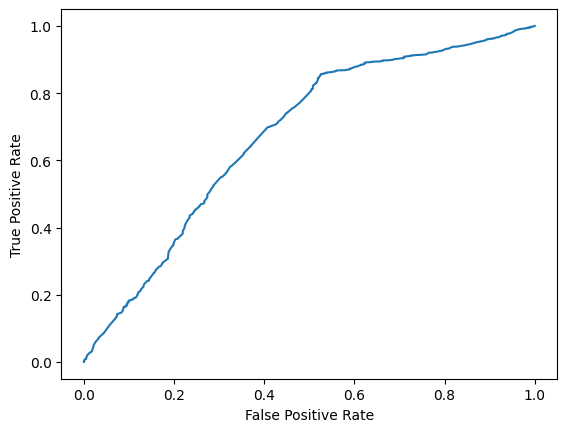

In [71]:
y_proba = clf.predict_proba(X_test)[:, 1] 
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

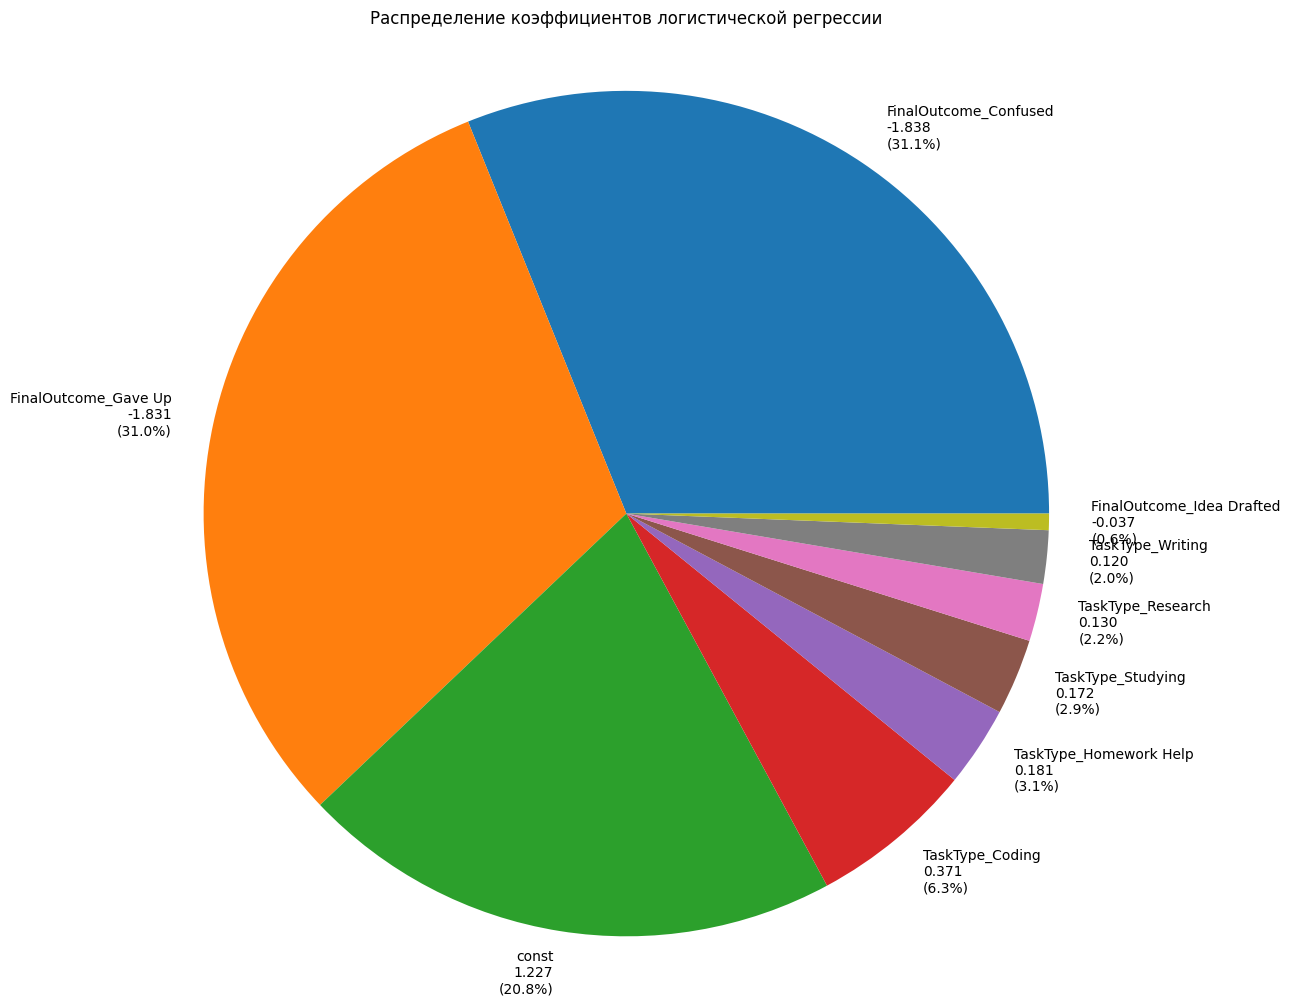

In [75]:
coef_df = pd.DataFrame({
    "feature": res.params.index,
    "coef": res.params.values
})

coef_df['abs_coef'] = np.abs(coef_df['coef'])
coef_df['pct'] = coef_df['abs_coef'] / coef_df['abs_coef'].sum() * 100
coef_df = coef_df.sort_values('abs_coef', ascending=False)

plt.figure(figsize=(12, 12))
plt.pie(
    coef_df['pct'],
    labels=[f"{name}\n{coef:.3f}\n({pct:.1f}%)" 
           for name, coef, pct in zip(coef_df['feature'], coef_df['coef'], coef_df['pct'])],
    startangle=0,
    textprops={'fontsize': 10}
)

plt.title('Распределение коэффициентов логистической регрессии', pad=20)
plt.axis('equal')
plt.show()

Была построена финальная модель прогноза UsedAgain (после исключения всех не значимых признаков). точность модели на тествовой выборке = 0.7432 и ROC-AUC = 0.67473, что значит, что модель неплохо предсказывает UsedAgain. Модель плохо предсказывает результат 0, это можно обьяснить дисбалансом в данных, так как из первичного анализа знаем, что: доля "0", всего 29,4%. В итоге результат предсказывания зависит от 2 переменных: во многом от FinalOutcome (более 60% влияния) и вторично от TaskType (около 17% влияния), при чем стоит обратить внимание что самое значимое влияние оказывают значения FinalOutcome = Gave Up и Confused, что довольно логично, если задание не выполнено или результат неудовлетворительный, то студент врядли вернется к ИИ-помошнику.